# Site Analysis notebooks

This notebook handles the site analysis based work in the paper. This forms the basis of the analysis performed to plot figures 7, 9 and 12 in the paper.

To begin with we need to set up a set of site analysis objects

In [1]:
import numpy as np
import os
from pymatgen.io.vasp import Poscar
from pymatgen.io.vasp import Poscar, Xdatcar
import numpy as np
import operator
from site_analysis.polyhedral_site import PolyhedralSite
from site_analysis.atom import atoms_from_species_string
from site_analysis.trajectory import Trajectory
from site_analysis.tools import get_vertex_indices
from site_analysis.atom import atoms_from_species_string


structure = Poscar.from_file('../POSCAR').structure
print(structure.composition)

#This section builds a model of the structure with fluoride ions on every site including octahedral ones
#Octahedral sites are obtained by shifting the positions of cations.
coords = np.array(structure.frac_coords[:108,:])+np.array([1/6,0,0])
for k in range(len(coords)):
    structure.append("F",coords[k])

#We need identify the defusing fluoride ions which we do here
atoms = atoms_from_species_string(Poscar.from_file('../POSCAR').structure, 'F')

all_f_structure = structure
vertex_species = ['Ba',"Sn"]
centre_species = 'F'

# find atom indices (within species) for all polyhedra vertex atoms
vertex_indices = np.array(get_vertex_indices(structure, centre_species=centre_species, 
                                             vertex_species=vertex_species, cutoff=4.3))

# We then create sites and trajectory objects
sites = PolyhedralSite.sites_from_vertex_indices(vertex_indices)
trajectory = Trajectory(sites=sites,
                        atoms=atoms)
trajectory.reset()

# The trajectory files must then be loaded and processed as a site analysis trajectory object
from tqdm import tqdm
structures = []
for i in tqdm(range(1,54)):
    xdatcar = Xdatcar(f'trajectories/r{i}/XDATCAR')
    structures.extend(xdatcar.structures)
for timestep, s in tqdm(enumerate(structures)):
    trajectory.append_timestep(s, t=timestep)

Ba54 Sn54 F216


/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|███████████████████████████████████████████| 53/53 [02:30<00:00,  2.84s/it]
15900it [21:42, 12.21it/s]


We now move to manipulating the trajectory object

In [2]:
n_atoms=216
n_frames=15900

Set up our figure formatting environment

In [3]:
from figure_formatting import figure_formatting as ff

ff.set_formatting()

We then create a list of tin coordination numbers for sites, in a singular object, we will need this throughout our data processing.

In [5]:
ntins=[]
for site in sites:
    ntins.append(np.sum(np.array(site.get_vertex_species(all_f_structure))=='Sn'))

We then parse through the site analysis object to create a simple list trajectory fo each atom, and the number of hops each atom makes

In [6]:
trajectories=[]
hops=[]
for k in range(108,324):
    buf_list=[]
    buffer=trajectory.atom_by_index(k).trajectory
    count =0
    for item in buffer:

            if count == 0:
                count +=1
                buf_list.append(item)
            elif type(item)!=int:
                pass
            elif buf_list[-1]==item:
                pass
            else:
                count +=1
                buf_list.append(item)

    trajectories.append(np.array(buf_list))
    hops.append(count-1)


The trajectory object is mixed with the site analysis object in order to make a new trajectory list called site_numbers which lists the number of tins coordinated to sites which fluroine atoms hop between.

In [7]:
site_numbers=[]
ntins=np.array(ntins)
for atoms in trajectories:
    buffer=[]
    for ats in atoms:
        buffer.append(ntins[ats])
    site_numbers.append(buffer)


We then create a second ntins list, called ntins_tot, this second list increases the coordination number of octahedral sites by ten, meaning that a site type label is created where the number of units in the number is the number of tins, while the tens value is set to 0 for tetrahedral sites and 1 for octahedral sites.

In [8]:
ntins_tot=np.array(ntins)
ntins_tot[n_atoms:]+=10

we then run a hop characterisation loop, this works out when hops between sites occur in the trajectory and whether those hops are progressive or returning

In [9]:
hop_dimensionality=[]
forward_dimensionality=[]
shoto_dimensionality=[]
shoto_forward_dimensionality=[]
hop_along=[]
linear=[]
shoto=[]
alles=0

for line in trajectories:
    last=1000 #the values of these two 
    prior=1000 #the values of these two 
    nb=[]
    nf=[]
    shoto=[]
    shoto_forward=[]
    hop_along.append(len(np.unique(line)))
    linear.append(np.sum(np.unique(line)))
    for element in line:
        if element is not None:
            if len(nb)==0:
                nb.append(ntins_tot[element])
                shoto.append(element)
                prior=last
                last=element
            elif last!=element:
                shoto.append(element)
                echo=element
                if element >n_atoms:
                    nb.append(ntins_tot[element])
                    prior=last
                    last=element
                else:
                    if prior!= element:
                        nb.append(ntins_tot[element])
                        nf.append(nb[-2])
                        nf.append(nb[-1])
                        shoto_forward.append(shoto[-2])
                        shoto_forward.append(shoto[-1])
                        prior=last
                        last=element
                    else:
                        nb.append(ntins_tot[element])
                        prior=last
                        last=element
    hop_dimensionality.append([nb])
    forward_dimensionality.append([nf])
    shoto_dimensionality.append([shoto])
    shoto_forward_dimensionality.append([shoto_forward])


    alles+=np.sum(np.unique(line)<n_atoms)-1
    linear.append(np.unique(line)<n_atoms)

This marks the end of the pre calculations

# Plotting occupancies

We then start running occupancy calculations in order to plot occupancies

In [10]:
toccupancy=[]
letoc=[]
for line in trajectory.at:
   lol= np.array(line)
   lol=lol[lol > n_atoms]
   toccupancy.append(ntins[lol])
   letoc.append(len(toccupancy[-1]))
tettoccupancy=[]
tetletoc=[]
for line in trajectory.at:
   lol= np.array(line)
   lol=lol[lol < n_atoms]
   tettoccupancy.append(ntins[lol])
   tetletoc.append(len(toccupancy[-1]))
lin_toccupancy=[]
for line in toccupancy:
    lin_toccupancy.extend(line)
tetlin_toccupancy=[]
for line in tettoccupancy:
    tetlin_toccupancy.extend(line)
tist=np.histogram(ntins[:n_atoms],bins=np.arange(-.5,4.51,1),density=True)
oist=np.histogram(np.array(tetlin_toccupancy).ravel(),bins=np.arange(-.5,4.51,1),density=True)

We calculate the occupancy of tetrahedral sites at this point

In [11]:
tetrahedral_occupancy=len(tetlin_toccupancy)/n_frames/n_atoms
print(tetrahedral_occupancy)

0.6454481132075471


We move now to regenerate the occupancy plots shown in figure 7.

0.049078926935321066
0.137364508113984
0.16718281698889662
0.07463991769547325
0.002032572404689805


/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  from ipykernel import kernelapp as app


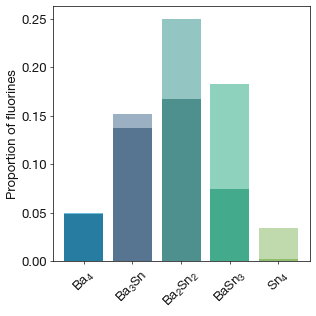

In [12]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(figsize=(4.5,4.5))
colorlist=['#277DA1','#577590','#4D908E','#43AA8B','#90BE6D']
colorlist_unoc=['#70BCDC','#9BB0C3','#93C5C3','#8ED2BE','#C0DAAD']
oc=[]
unoc=[]
for n in range(5):
    plt.bar((np.array(tist[1])[:-1][n]+np.array(tist[1])[1:][n])/2,tist[0][n]/3*2,color=colorlist_unoc[n])
    unoc.append(tist[0][n]/3*2)
    print(oist[0][n]*tetrahedral_occupancy/3*2)
    plt.bar((np.array(oist[1])[:-1][n]+np.array(oist[1])[1:][n])/2,oist[0][n]*tetrahedral_occupancy/3*2,color=colorlist[n],label='Occupancy')
    oc.append(oist[0][n]*tetrahedral_occupancy/3*2)
ax.set_xticks([0,1,2,3,4],['Ba$_{4}$','Ba$_{3}$Sn','Ba$_{2}$Sn$_{2}$','BaSn$_{3}$','Sn$_{4}$'],rotation=45,fontsize=13)
ax.tick_params(axis='y',labelsize=13)
plt.tight_layout(pad=50)
plt.subplots_adjust(bottom=0.2)
plt.ylabel("Proportion of fluorines", fontsize=13)
plt.ylim(0)
plt.tight_layout()
plt.savefig("new_occupancies.pdf")

In [13]:
tistD=np.histogram(ntins[:n_atoms],bins=np.arange(-.5,4.51,1))
oistD=np.histogram(np.array(tetlin_toccupancy).ravel(),bins=np.arange(-.5,4.51,1))

tet_base=oistD[0]/tistD[0]/n_frames

tistDoct=np.histogram(ntins[n_atoms:],bins=np.arange(-.5,6.51,1))
oistDoct=np.histogram(np.array(lin_toccupancy).ravel(),bins=np.arange(-.5,6.51,1))

oct_base=oistDoct[0]/tistDoct[0]/n_frames

/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  if __name__ == "__main__":


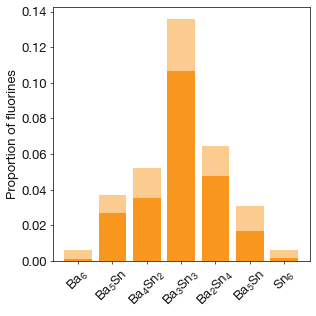

In [15]:
tist=np.histogram(ntins[216:],bins=np.arange(-.5,6.51,1),density=True)
oist=np.histogram(np.array(lin_toccupancy).ravel(),bins=np.arange(-.5,6.51,1),density=True)
fig, ax =plt.subplots(figsize=(4.5,4.5))


plt.bar((np.array(tist[1])[:-1]+np.array(tist[1])[1:])/2,tist[0]/3,color='#FCCB90',label='Sites')
plt.bar((np.array(oist[1])[:-1]+np.array(oist[1])[1:])/2,oist[0]*(1-tetrahedral_occupancy)/3*2,color='#F8961E',label='Occupancy')
ax.set_xticks([0,1,2,3,4],['FBa$_{4}$','FBa$_{3}$Sn','FBa$_{2}$Sn$_{2}$','FBaSn$_{3}$','FSn$_{4}$'],rotation=45,fontsize=13)
plt.tight_layout(pad=50)
plt.subplots_adjust(bottom=0.2)
ax.tick_params(axis='y',labelsize=13)
plt.ylabel("Proportion of fluorines", fontsize=13)

ax.set_xticks([0,1,2,3,4,5,6],['Ba$_{6}$','Ba$_{5}$Sn','Ba$_{4}$Sn$_{2}$','Ba$_{3}$Sn$_{3}$','Ba$_{2}$Sn$_{4}$','Ba$_{5}$Sn','Sn$_{6}$'],rotation=45,fontsize=13)

plt.tight_layout()
plt.savefig("new_occupancies_oct.pdf")

This is followed by calculating and storing the number of occupied and unoccupied sites for future use.

In [14]:
for kount in range(len(tist[0]/3)):
    unoc.append((tist[0]/3)[kount])
    oc.append((oist[0]*(1-tetrahedral_occupancy)/3*2)[kount])

# Calculating site free energies

We then use the number of occurances to calculate the site population densities which in turn allows us to calculate site free energies

In [16]:
ocurrances=np.histogram(np.array(trajectory.at).ravel(),bins=np.arange(-.5,324.5,1))[0]
en_pops=np.log(ocurrances/len(structures)/n_atoms)*600*8.617e-5*-1
line=np.log(np.sort(ocurrances)[int(324/3)]/len(structures)/n_atoms)*600*8.617e-5*-1-np.min(en_pops)
en_pops-=np.min(en_pops)

We then develop an indexing systems for site types for both tetrahedral and octahedral sites.

In [20]:
tet_tins=np.array(ntins)[:n_atoms]
oct_tins=np.array(ntins)[n_atoms:]

We then use this indexing to obtain list of occurances and site energies for each type of sites.

In [21]:

tet_0_oc = ocurrances[np.where([tet_tins==0])[1]]
tet_1_oc = ocurrances[np.where([tet_tins==1])[1]]
tet_2_oc = ocurrances[np.where([tet_tins==2])[1]]
tet_3_oc = ocurrances[np.where([tet_tins==3])[1]]
tet_4_oc = ocurrances[np.where([tet_tins==4])[1]]


oct_0_oc = ocurrances[n_atoms+np.where([oct_tins==0])[1]]
oct_1_oc = ocurrances[n_atoms+np.where([oct_tins==1])[1]]
oct_2_oc = ocurrances[n_atoms+np.where([oct_tins==2])[1]]
oct_3_oc = ocurrances[n_atoms+np.where([oct_tins==3])[1]]
oct_4_oc = ocurrances[n_atoms+np.where([oct_tins==4])[1]]
oct_5_oc = ocurrances[n_atoms+np.where([oct_tins==5])[1]]
oct_6_oc = ocurrances[n_atoms+np.where([oct_tins==6])[1]]


In [22]:

tet_0_en = en_pops[np.where([tet_tins==0])[1]]
tet_1_en = en_pops[np.where([tet_tins==1])[1]]
tet_2_en = en_pops[np.where([tet_tins==2])[1]]
tet_3_en = en_pops[np.where([tet_tins==3])[1]]
tet_4_en = en_pops[np.where([tet_tins==4])[1]]


oct_0_en = en_pops[n_atoms+np.where([oct_tins==0])[1]]
oct_1_en = en_pops[n_atoms+np.where([oct_tins==1])[1]]
oct_2_en = en_pops[n_atoms+np.where([oct_tins==2])[1]]
oct_3_en = en_pops[n_atoms+np.where([oct_tins==3])[1]]
oct_4_en = en_pops[n_atoms+np.where([oct_tins==4])[1]]
oct_5_en = en_pops[n_atoms+np.where([oct_tins==5])[1]]
oct_6_en = en_pops[n_atoms+np.where([oct_tins==6])[1]]

oct_all_en = en_pops[n_atoms:]

In [23]:
from scipy.stats import gaussian_kde


at this point we generate KDEs and the use them to reproduce figure 7c of the main paper

In [24]:
x = np.linspace(-.1,.5,10000)

density=gaussian_kde(oct_all_en,bw_method=.5)
y=density(x)
density=gaussian_kde(tet_0_en,bw_method=.5)
                     
yt0=density(x)

density=gaussian_kde(tet_1_en,bw_method=.5)
yt1=density(x)
density=gaussian_kde(tet_2_en,bw_method=.5)
yt2=density(x)
density=gaussian_kde(tet_3_en,bw_method=.5)
yt3=density(x)
density=gaussian_kde(tet_4_en,bw_method=.5)
yt4=density(x)

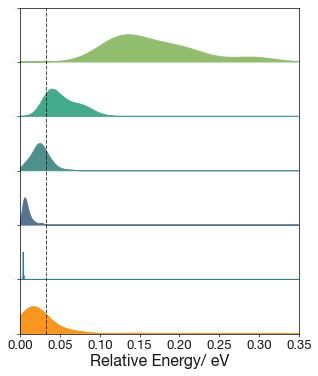

In [23]:
fig, ax =plt.subplots(figsize=(5,6))

plt.fill_between(x,yt4/np.max(yt4)+10,10,color=colorlist[4])
plt.fill_between(x,yt3/np.max(yt3)+8,8,color=colorlist[3])
plt.fill_between(x,yt2/np.max(yt2)+6,6,color=colorlist[2])
plt.fill_between(x,yt1/np.max(yt1)+4,4,color=colorlist[1])
plt.fill_between(x,yt0/np.max(yt0)+2,2,color=colorlist[0])
plt.xlim(-0,.35)
plt.ylim(0,12)
ax.tick_params(axis='x',labelsize=13)

ax.tick_params(axis='y',labelsize=0)

plt.plot([line,line],[0,12],linestyle='dashed',color='black')
plt.fill_between(x,y/np.max(y),color='#F8961E')
plt.xlabel("Relative Energy/ eV", fontsize=16)
plt.savefig("statistical_mechanical_band_structure.pdf")

# Calculating hop frequencies

We now return to calculating hop frequencies, returning the dimensionality objects we iterate through them indexing all varieites of hop.

Strictly this would allow us to plot 2d data with where hops are going to also being consideredm this turned up to a degree as one would expect so we do not present it. The functionality to do this remains in the workflow.

In [26]:
hop_to=[]
hop_from=[]
for looper in hop_dimensionality:
    line=looper[0]
    if len(line)>1:
        hop_to.extend(line[1:])
        hop_from.extend(line[:-1])

In [27]:
forth_to=[]
forth_from=[]
for looper in forward_dimensionality:
    line=looper[0]
    if len(line)>1:
        forth_to.extend(line[1:])
        forth_from.extend(line[:-1])

We then plot the graphs, the first two graphs here present an alternative view from that in the paper. They are not normalised by a sites occupation, this means they give a material's eye view of where hops are coming from, note that hop frequency trails off due to lower occupation.

/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  # Remove the CWD from sys.path while we load stuff.


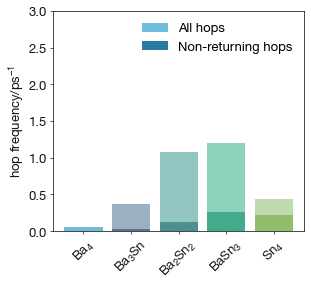

In [31]:
fig, ax =plt.subplots(figsize=(4.5,4.5))
colorlist=['#277DA1','#577590','#4D908E','#43AA8B','#90BE6D']
colorlist_unoc=['#70BCDC','#9BB0C3','#93C5C3','#8ED2BE','#C0DAAD']
for n in range(5):
    plt.bar([0,1,2,3,4][n],(np.histogram(hop_from,bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/np.histogram(ntins[:n_atoms],bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/(n_frames*10/1000))[n],color=colorlist_unoc[n])
    plt.bar([0,1,2,3,4][n],(np.histogram(forth_from,bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/np.histogram(ntins[:n_atoms],bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/(n_frames*10/1000))[n],color=colorlist[n])
plt.ylabel('hop frequency/ps$^{-1}$',fontsize=13)
ax.legend(['All hops','Non-returning hops'],fontsize=13)
ax.set_xticks([0,1,2,3,4],['FBa$_{4}$','FBa$_{3}$Sn','FBa$_{2}$Sn$_{2}$','FBaSn$_{3}$','FSn$_{4}$'])#,rotation=45,fontsize=13)
plt.tight_layout(pad=50)
plt.ylim(-0.0,3)
plt.subplots_adjust(bottom=0.2)
ax.set_xticks([0,1,2,3,4],['Ba$_{4}$','Ba$_{3}$Sn','Ba$_{2}$Sn$_{2}$','BaSn$_{3}$','Sn$_{4}$'],rotation=45,fontsize=13)
ax.tick_params(axis='y',labelsize=13)
plt.savefig('Hops_tet.pdf')


/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  import sys


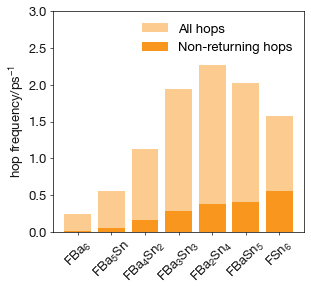

In [32]:
fig, ax =plt.subplots(figsize=(4.5,4.5))
plt.bar([0,1,2,3,4,5,6],np.histogram(hop_from,bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5])+10)[0]/np.histogram(ntins[216:],bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]))[0]/(n_frames*10/1000),color='#FCCB90')
plt.bar([0,1,2,3,4,5,6],np.histogram(forth_from,bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5])+10)[0]/np.histogram(ntins[216:],bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]))[0]/(n_frames*10/1000),color='#F8961E')
plt.ylabel('hop frequency/ps$^{-1}$',fontsize=13)
ax.legend(['All hops','Non-returning hops'],fontsize=13)
ax.set_xticks([0,1,2,3,4],['FBa$_{4}$','FBa$_{3}$Sn','FBa$_{2}$Sn$_{2}$','FBaSn$_{3}$','FSn$_{4}$'])#,rotation=45,fontsize=13)
plt.tight_layout(pad=50)
plt.ylim(0,3)
plt.subplots_adjust(bottom=0.2)
ax.set_xticks([0,1,2,3,4,5,6],['FBa$_{6}$','FBa$_{5}$Sn','FBa$_{4}$Sn$_{2}$','FBa$_{3}$Sn$_{3}$','FBa$_{2}$Sn$_{4}$','FBaSn$_{5}$','FSn$_{6}$'],rotation=45,fontsize=13)
ax.tick_params(axis='y',labelsize=13)
plt.ylim(0,3)
plt.ylabel('hop frequency/ps$^{-1}$',fontsize=13)
plt.subplots_adjust(bottom=0.2)

plt.savefig('Hops_oct.pdf')


We then plot the version of this graph shis is present in

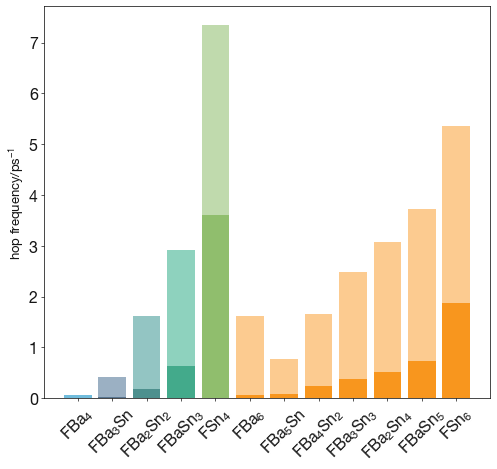

In [34]:
fig, ax =plt.subplots(figsize=(8,8))
colorlist=['#277DA1','#577590','#4D908E','#43AA8B','#90BE6D']
colorlist_unoc=['#70BCDC','#9BB0C3','#93C5C3','#8ED2BE','#C0DAAD']
weight_list=np.append(tet_base,oct_base)
for n in range(5):
    plt.bar([0,1,2,3,4][n],(np.histogram(hop_from,bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/np.histogram(ntins[:216],bins=[-.5,.5,1.5,2.5,3.5,4.5])[0])[n]/weight_list[n]/(n_frames*10/1000),color=colorlist_unoc[n])
    plt.bar([0,1,2,3,4][n],(np.histogram(forth_from,bins=[-.5,.5,1.5,2.5,3.5,4.5])[0]/np.histogram(ntins[:216],bins=[-.5,.5,1.5,2.5,3.5,4.5])[0])[n]/weight_list[n]/(n_frames*10/1000),color=colorlist[n])
plt.bar([0+5,1+5,2+5,3+5,4+5,5+5,6+5],np.histogram(hop_from,bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5])+10)[0]/np.histogram(ntins[216:],bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]))[0]/weight_list[5:]/(n_frames*10/1000),color='#FCCB90')
plt.bar([0+5,1+5,2+5,3+5,4+5,5+5,6+5],np.histogram(forth_from,bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5])+10)[0]/np.histogram(ntins[216:],bins=np.array([-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5]))[0]/weight_list[5:]/(n_frames*10/1000),color='#F8961E')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11],['FBa$_{4}$','FBa$_{3}$Sn','FBa$_{2}$Sn$_{2}$','FBaSn$_{3}$','FSn$_{4}$','FBa$_{6}$','FBa$_{5}$Sn','FBa$_{4}$Sn$_{2}$','FBa$_{3}$Sn$_{3}$','FBa$_{2}$Sn$_{4}$','FBaSn$_{5}$','FSn$_{6}$'],rotation=45,fontsize=16)
ax.tick_params(axis='y',labelsize=16)
plt.ylabel('hop frequency/ps$^{-1}$',fontsize=13)
plt.subplots_adjust(bottom=0.2)
plt.savefig("hops_new.pdf",dpi=300)

# Exploring bias

The final figure we will generate in this book is the colourmap which shows the origin of dipole bias.
We start by loading the average dipole location hexamin_loc that we generated in the polarisation section.

In [35]:
hexamin_loc=np.loadtxt('../Polarisation/hexamin_loc')

We then calculate the nearest neighbout cations to each tin using polyhedral analysis and the starting posca.

In [36]:
from pymatgen.core import Structure, Lattice
from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
recipe = PolyhedraRecipe(method='distance cutoff',
                     coordination_cutoff=4.6,
                     central_atoms='Sn',
                     vertex_atoms=['Sn','Ba'])
configs = [Configuration(structure=Structure.from_file('../POSCAR'), recipes=[recipe])]

polyhedra = [p for c in configs for p in c.polyhedra]

We then work out the number of nearest neighbour tins on each face of the cubic tin site

In [38]:
store= np.zeros((54,6))
for counta in range(len(polyhedra)):
    polset=polyhedra[counta].vertex_vectors.copy()
    polset[abs(polyhedra[counta].vertex_vectors)<.1]=0
    polset=np.round(polset/3.05)
    for count in range(len(polset)):
        if polyhedra[counta].vertex_labels[count] == 'Sn':
            if int(polset[count][2])== -1:
                store[counta,5]+=1
            elif int(polset[count][2])== 1:
                store[counta,4]+=1
            if int(polset[count][1])== -1:
                store[counta,3]+=1
            elif int(polset[count][1])== 1:
                store[counta,2]+=1
            if int(polset[count][0])== -1:
                store[counta,1]+=1
            elif int(polset[count][0])== 1:
                store[counta,0]+=1
        else:
            pass

In [39]:
store2=np.zeros(np.shape(store))
store2[:,1]=store[:,0]
store2[:,0]=store[:,1]
store2[:,2]=store[:,3]
store2[:,3]=store[:,2]
store2[:,4]=store[:,5]
store2[:,5]=store[:,4]

We then calculate the proportion of time the dipole points to each face

In [40]:
hex_block=[]
for k in range(54):
    hex_block.append(np.histogram(hexamin_loc[:,k],bins=np.arange(0,6.1,1),density=True)[0])


We then add these proportions and related normalisaton coeffficients to 5,5 storage arrays we will use to make the colormap.

In [44]:
vals=np.zeros((5,5))
counting_base=np.zeros((5,5))
hex_block=np.array(hex_block)
for k in range(np.shape(hex_block)[0]):
    for l in range(np.shape(hex_block)[1]):
        vals[int(store[k,l]),int(store2[k,l])]+=hex_block[k,l]
        counting_base[int(store[k,l]),int(store2[k,l])]+=1

Finally we plot the colormap

/Users/swc57/miniconda3/envs/p3p7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


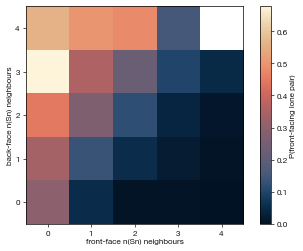

In [46]:
from cmcrameri import cm
plt.figure()
plt.imshow(vals/counting_base,cmap=cm.lipari,vmin=0)
plt.xlim(-0.5,4.5)
plt.ylim(-0.5,4.5)
plt.xlabel('front-face n(Sn) neighbours')
plt.ylabel('back-face n(Sn) neighbours')
cbar=plt.colorbar()
cbar.set_label('P(front-facing lone pair)')
plt.savefig("orientation.pdf")